In [1]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Loading base images and coverting them to grayscale
face = cv2.imread("Images/rakshith_new_photo.JPG")
body = cv2.imread("Images/virat.jpg")

In [3]:
face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

# Create empty matrices in the images' shapes
height, width = face_gray.shape
mask = np.zeros((height, width), np.uint8)

height, width, channels = body.shape

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Getting landmarks for the face that will be swapped into to the body
rect = detector(face_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks = predictor(face_gray, rect)
landmarks_points = [] 

def get_landmarks(landmarks, landmarks_points):
  for n in range(68):
      x = landmarks.part(n).x
      y = landmarks.part(n).y
      landmarks_points.append((x, y))

get_landmarks(landmarks, landmarks_points)

points = np.array(landmarks_points, np.int32)

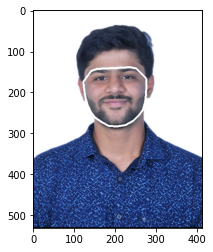

In [5]:
convexhull = cv2.convexHull(points) 

face_cp = face.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(face_cp, [convexhull], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

face_image_1 = cv2.bitwise_and(face, face, mask=mask)

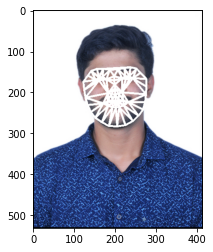

In [6]:
rect = cv2.boundingRect(convexhull)

subdiv = cv2.Subdiv2D(rect) # Creates an instance of Subdiv2D
subdiv.insert(landmarks_points) # Insert points into subdiv
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

indexes_triangles = []
face_cp = face.copy()

def get_index(arr):
    index = 0
    if arr:
        index = arr[0][0]
    return index

for triangle in triangles :

    # Gets the vertex of the triangle
    pt1 = (triangle[0], triangle[1])
    pt2 = (triangle[2], triangle[3])
    pt3 = (triangle[4], triangle[5])
    
    # Draws a line for each side of the triangle
    cv2.line(face_cp, pt1, pt2, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt2, pt3, (255, 255, 255), 3,  0)
    cv2.line(face_cp, pt3, pt1, (255, 255, 255), 3,  0)

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = get_index(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = get_index(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = get_index(index_pt3)

    # Saves coordinates if the triangle exists and has 3 vertices
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        vertices = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(vertices)

# Draw delaunay triangles
plt.imshow(cv2.cvtColor(face_cp, cv2.COLOR_BGR2RGB)) 

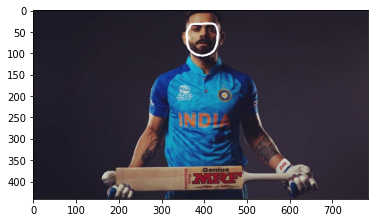

In [7]:
# Getting landmarks for the face that will have the first one swapped into
rect2 = detector(body_gray)[0]

# This creates a with 68 pairs of integer values — these values are the (x, y)-coordinates of the facial structures 
landmarks_2 = predictor(body_gray, rect2)
landmarks_points2 = []

# Uses the function declared previously to get a list of the landmark coordinates
get_landmarks(landmarks_2, landmarks_points2)

# Generates a convex hull for the second person
points2 = np.array(landmarks_points2, np.int32)
convexhull2 = cv2.convexHull(points2)

body_cp = body.copy()
plt.imshow(cv2.cvtColor((cv2.polylines(body_cp, [convexhull2], True, (255,255,255), 3)), cv2.COLOR_BGR2RGB))

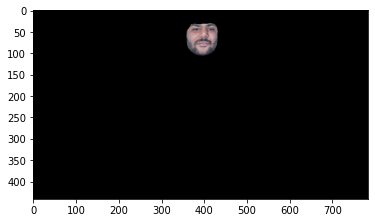

In [8]:
lines_space_new_face = np.zeros((height, width, channels), np.uint8)
body_new_face = np.zeros((height, width, channels), np.uint8)

height, width = face_gray.shape
lines_space_mask = np.zeros((height, width), np.uint8)


for triangle in indexes_triangles:

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points[triangle[0]]
    pt2 = landmarks_points[triangle[1]]
    pt3 = landmarks_points[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_triangle = face[y: y+height, x: x+widht]
    cropped_mask = np.zeros((height, widht), np.uint8)

    # Fills triangle to generate the mask
    points = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, points, 255)

    # Draws lines for the triangles
    cv2.line(lines_space_mask, pt1, pt2, 255)
    cv2.line(lines_space_mask, pt2, pt3, 255)
    cv2.line(lines_space_mask, pt1, pt3, 255)

    lines_space = cv2.bitwise_and(face, face, mask=lines_space_mask)
    # Calculates the delaunay triangles of the second person's face

    # Coordinates of the first person's delaunay triangles
    pt1 = landmarks_points2[triangle[0]]
    pt2 = landmarks_points2[triangle[1]]
    pt3 = landmarks_points2[triangle[2]]

    # Gets the delaunay triangles
    (x, y, widht, height) = cv2.boundingRect(np.array([pt1, pt2, pt3], np.int32))
    cropped_mask2 = np.zeros((height,widht), np.uint8)

    points2 = np.array([[pt1[0]-x, pt1[1]-y], [pt2[0]-x, pt2[1]-y], [pt3[0]-x, pt3[1]-y]], np.int32)
    cv2.fillConvexPoly(cropped_mask2, points2, 255)

    points =  np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)  # Warps the content of the first triangle to fit in the second one
    dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

    # Joins all the distorted triangles to make the face mask to fit in the second person's features
    body_new_face_rect_area = body_new_face[y: y+height, x: x+widht]
    body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # Creates a mask
    masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

    # Adds the piece to the face mask
    body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
    body_new_face[y: y+height, x: x+widht] = body_new_face_rect_area
  
plt.imshow(cv2.cvtColor(body_new_face, cv2.COLOR_BGR2RGB))

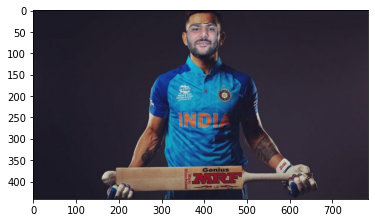

In [9]:
body_face_mask = np.zeros_like(body_gray)
body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
body_face_mask = cv2.bitwise_not(body_head_mask)

body_maskless = cv2.bitwise_and(body, body, mask=body_face_mask)
result = cv2.add(body_maskless, body_new_face)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

True

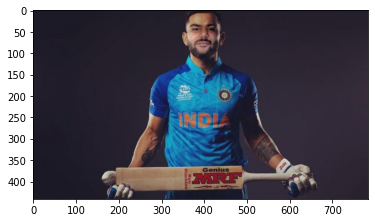

In [10]:
(x, y, widht, height) = cv2.boundingRect(convexhull2)
center_face2 = (int((x+x+widht)/2), int((y+y+height)/2))
seamlessclone = cv2.seamlessClone(result, body, body_head_mask, center_face2, cv2.NORMAL_CLONE)
plt.imshow(cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB))
cv2.imwrite("Results/result1.png", seamlessclone)